In [1]:
library(mgcv)

Loading required package: nlme
This is mgcv 1.8-12. For overview type 'help("mgcv-package")'.


In [2]:
DATA_PATH =  '../../data/cluster/year/'
list.files(DATA_PATH)

[1] " X_big_test.csv"     " X_big_train.csv"    " X_big_valid.csv"   
 [4] " y_big_test.csv"     " y_big_train.csv"    " y_big_valid.csv"   
 [7] "weights.bestNN.hdf5" "X_test.csv"          "X_train.csv"        
[10] "X_valid.csv"         "y_test.csv"          "y_train.csv"        
[13] "y_valid.csv"

In [49]:
X.train <- read.csv(paste(DATA_PATH, 'X_train.csv', sep=''))
cat('X.train:', dim(X.train), '\n')
X.valid <- read.csv(paste(DATA_PATH, 'X_valid.csv', sep=''))
cat('X.valid:', dim(X.valid), '\n')
X.test  <- read.csv(paste(DATA_PATH, 'X_test.csv',  sep=''))
cat('X.test:', dim(X.test), '\n')
y.train <- read.csv(paste(DATA_PATH, 'y_train.csv', sep=''))
cat('y.train:', dim(y.train), '\n')
y.valid <- read.csv(paste(DATA_PATH, 'y_valid.csv', sep=''))
cat('y.valid:', dim(y.valid), '\n')
y.test  <- read.csv(paste(DATA_PATH, 'y_test.csv',  sep=''))
cat('y.test:', dim(y.test), '\n')

X.train: 529623 24 
X.valid: 176541 24 
X.test: 176541 24 
y.train: 529623 1 
y.valid: 176541 1 
y.test: 176541 1 


In [50]:
X.train <- cbind(y.train, X.train)
X.valid <- cbind(y.valid, X.valid)
X.test  <- cbind(y.test,  X.test)

In [51]:
names(X.train)

[1] "beetle"                  "year"                   
 [3] "meanTemp_Annual"         "meanTemp_AprAug"        
 [5] "meanTemp_Aug"            "meanMinTemp_DecFeb"     
 [7] "meanMinTemp_Oct"         "meanMinTemp_Jan"        
 [9] "meanMinTemp_Mar"         "meanMaxTemp_Aug"        
[11] "precip_meanAnnual"       "precip_JunAug"          
[13] "vegetation"              "precipPrevious_JunAug"  
[15] "precip_OctSep"           "precipPrevious_OctSep"  
[17] "precip_growingSeason"    "varPrecip_growingSeason"
[19] "elev_etopo1"             "lat"                    
[21] "lon"                     "studyArea"              
[23] "elev_srtm30"             "x"                      
[25] "y"

In [52]:
drop <- c('studyArea', 'elev_srtm30')
X.train <- X.train[, -which(names(X.train) %in% drop)]
X.valid <- X.valid[, -which(names(X.valid) %in% drop)]
X.test  <- X.test[,  -which(names(X.test) %in% drop)]
names(X.train)

[1] "beetle"                  "year"                   
 [3] "meanTemp_Annual"         "meanTemp_AprAug"        
 [5] "meanTemp_Aug"            "meanMinTemp_DecFeb"     
 [7] "meanMinTemp_Oct"         "meanMinTemp_Jan"        
 [9] "meanMinTemp_Mar"         "meanMaxTemp_Aug"        
[11] "precip_meanAnnual"       "precip_JunAug"          
[13] "vegetation"              "precipPrevious_JunAug"  
[15] "precip_OctSep"           "precipPrevious_OctSep"  
[17] "precip_growingSeason"    "varPrecip_growingSeason"
[19] "elev_etopo1"             "lat"                    
[21] "lon"                     "x"                      
[23] "y"

In [9]:
# Find the best exponential transform (x' = x^a) or log transform 
# (x' = log(x))that best normalizes the input vector x
get.best.transform <- function(x, 
                               min.exp=-2, 
                               max.exp=2, 
                               steps=100, 
                               min.x=NULL, 
                               include.log=T, 
                               plt=F, 
                               verbose=F) {
  t.string <- 'x'
  if (is.null(min.x)) { min.x <- min(x) }
    
  # Prevent 0 and negative values--not defined for certain tranformations
  if (min(x) <= 0) {
    xt <- x + abs(min.x) + 1
    t.string <- paste('(', t.string, ' + ', abs(min(x)) + 1, ')', sep='')
  } else {
    xt <- x
    t.string <- 'x'
  }
    
  exps <- seq(min.exp, max.exp, length=steps)
  ps <- rep(NA, steps)
    
  for (i in 1:length(exps)) {
    ex <- exps[i]
    ps[i] <- shapiro.test(xt^ex)$p
  }
    
  best.p <- which(ps == max(ps))[1]
  best.exp <- exps[best.p]
  best <- best.exp
    
  if (include.log) {
    if (shapiro.test(log(xt))$p > best.p) {
      t.string <- paste('log', t.string, sep='')
      xt <- log(xt)
      best <- 'log'
    } else {
      t.string <- paste(t.string, round(best.exp, 4), sep='^')
      xt <- xt^best.exp
    }
  }
    
  if (verbose) { cat(t.string, '\n')}
    
  if (plt) {
    plot(ps ~ exps, 
         xlab='exponent', 
         ylab='p (Shapiro-Wilk Test)', 
         type='l', 
         col=2)
    par(mfrow=c(1, 2))
    hist(x, main='x', col=4, xlab='')
    hist(xt, main=t.string, col=4, xlab='')
  }

  list(best=best, x.transform=xt)
}

(x + 1)^0.8283 


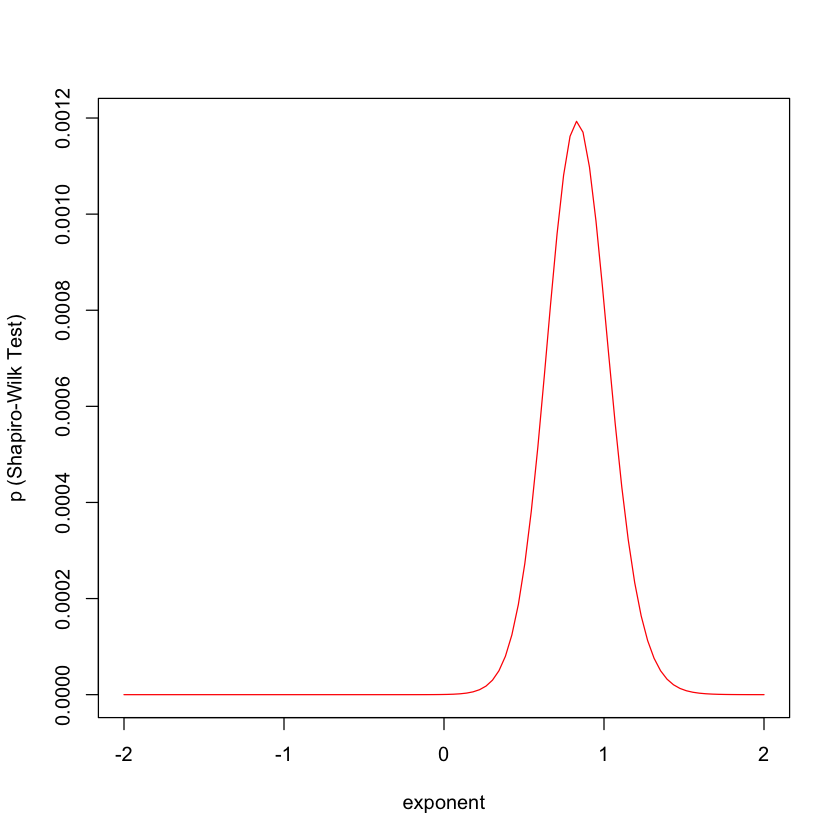

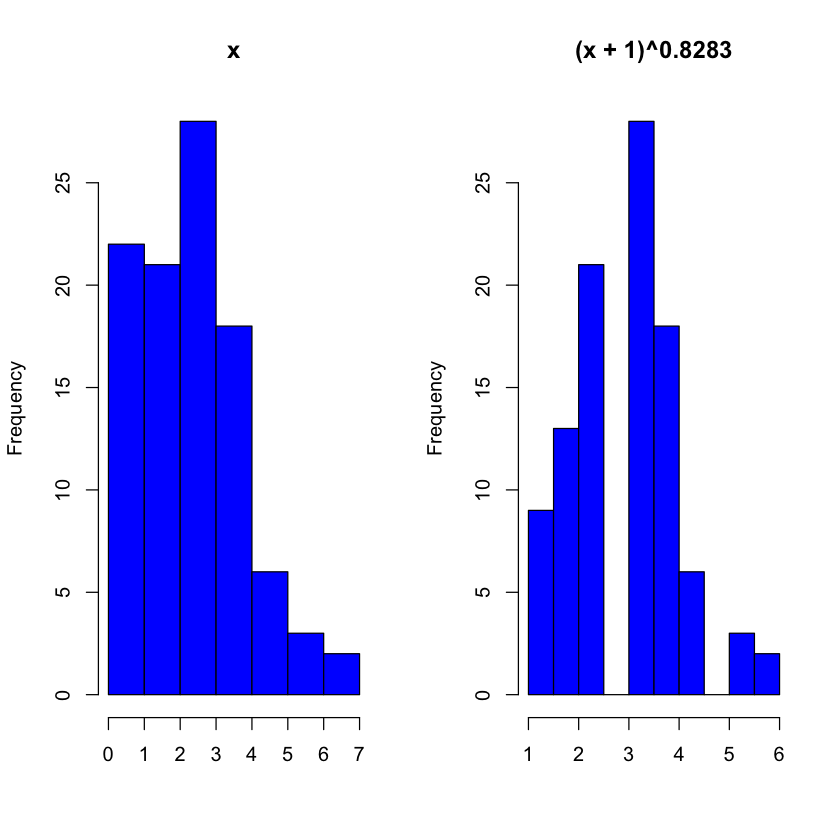

In [10]:
# Test
x <- rpois(100, 3)
xt <- get.best.transform(x, verbose=T, plt=T)

In [11]:
# get.best.transform() is limited to vectors of size <= 5000 because of the
# same limitation in shapiro.test():
shapiro.test(rnorm(5001))

ERROR: Error in shapiro.test(rnorm(5001)): sample size must be between 3 and 5000


In [39]:
# To compensate, we will take several random samples of size 5000, and 
# average their transformations
get.best.transform.big <- function(data, field, n.samples, plt=T, time=T) {
    
  start <- Sys.time()
  exps <- rep(NA, n.samples)
    
  for (s in 1:n.samples) {
    if (length(data) == 1) {
      x <- sample(data[, field], size=5000)
      min.x <- min(data[, field], na.rm=T)
    } else {
      x <- sample(data[[1]][, field], size=5000)
      min.xs <- rep(NA, length(data))
      for (i in 1:length(data)) {
        min.xs[i] <- min(data[[i]][, field], na.rm=T)
      }
      min.x <- min(min.xs)
    }
    
    x <- x[!is.na(x)]
    exps[s] <- get.best.transform(x, min.x=min.x, include.log=F)$best
  }

  if (plt) { hist(exps, main=field, col=4) }
  if (time) { cat('Time taken:', Sys.time() - start, '\n') }
    
  mean(exps)    
}

In [40]:
names(X.train)

[1] "beetle"                  "year"                   
 [3] "meanTemp_Annual"         "meanTemp_AprAug"        
 [5] "meanTemp_Aug"            "meanMinTemp_DecFeb"     
 [7] "meanMinTemp_Oct"         "meanMinTemp_Jan"        
 [9] "meanMinTemp_Mar"         "meanMaxTemp_Aug"        
[11] "precip_meanAnnual"       "precip_JunAug"          
[13] "vegetation"              "precipPrevious_JunAug"  
[15] "precip_OctSep"           "precipPrevious_OctSep"  
[17] "precip_growingSeason"    "varPrecip_growingSeason"
[19] "elev_etopo1"             "lat"                    
[21] "lon"                     "x"                      
[23] "y"

In [43]:
ignore <- c('beetle', 'year', 'lat', 'lon', 'x', 'y', 'vegetation')

meanTemp_Annual: 0.4897778
meanTemp_AprAug: 0.3060202
meanTemp_Aug: 0.137697
meanMinTemp_DecFeb: 0.9713939
meanMinTemp_Oct: -0.1194343
meanMinTemp_Jan: 1.064485
meanMinTemp_Mar: 1.355394
meanMaxTemp_Aug: 0.5649293
precip_meanAnnual: 0.05793939
precip_JunAug: 0.6671515
precipPrevious_JunAug: 0.6300606
precip_OctSep: 0.004686869
precipPrevious_OctSep: 0.06690909
precip_growingSeason: 0.4829899
varPrecip_growingSeason: 0.349899
elev_etopo1: 0.4753939


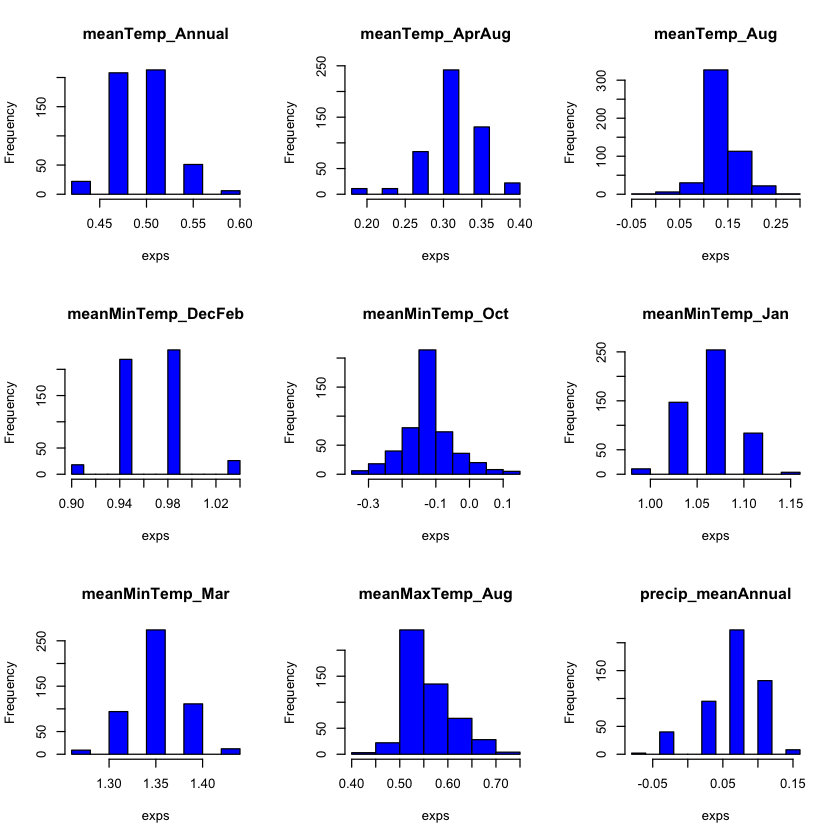

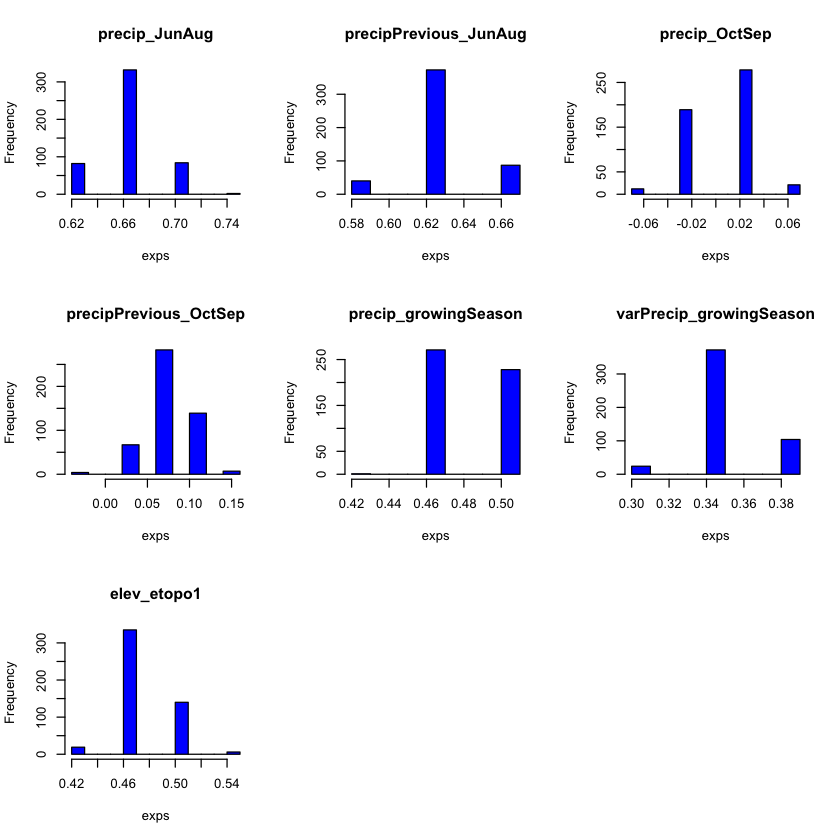

In [44]:
SAMPLES <- 500
best.exps <- c()
par(mfrow=c(3, 3))

for (field in names(X.train)) {
  if (!(field %in% ignore)) {
    min.x <- min(c(X.train[, field], X.valid[, field], X.test[, field]),
                 na.rm=T)
    best.exp <- get.best.transform.big(
        list(X.train, X.valid, X.test), field, SAMPLES, plt=T, time=F)
    cat(field, ': ', best.exp, '\n', sep='')
    best.exps[field] <- best.exp
  }
}

In [45]:
best.exps

meanTemp_Annual         meanTemp_AprAug            meanTemp_Aug 
            0.489777778             0.306020202             0.137696970 
     meanMinTemp_DecFeb         meanMinTemp_Oct         meanMinTemp_Jan 
            0.971393939            -0.119434343             1.064484848 
        meanMinTemp_Mar         meanMaxTemp_Aug       precip_meanAnnual 
            1.355393939             0.564929293             0.057939394 
          precip_JunAug   precipPrevious_JunAug           precip_OctSep 
            0.667151515             0.630060606             0.004686869 
  precipPrevious_OctSep    precip_growingSeason varPrecip_growingSeason 
            0.066909091             0.482989899             0.349898990 
            elev_etopo1 
            0.475393939

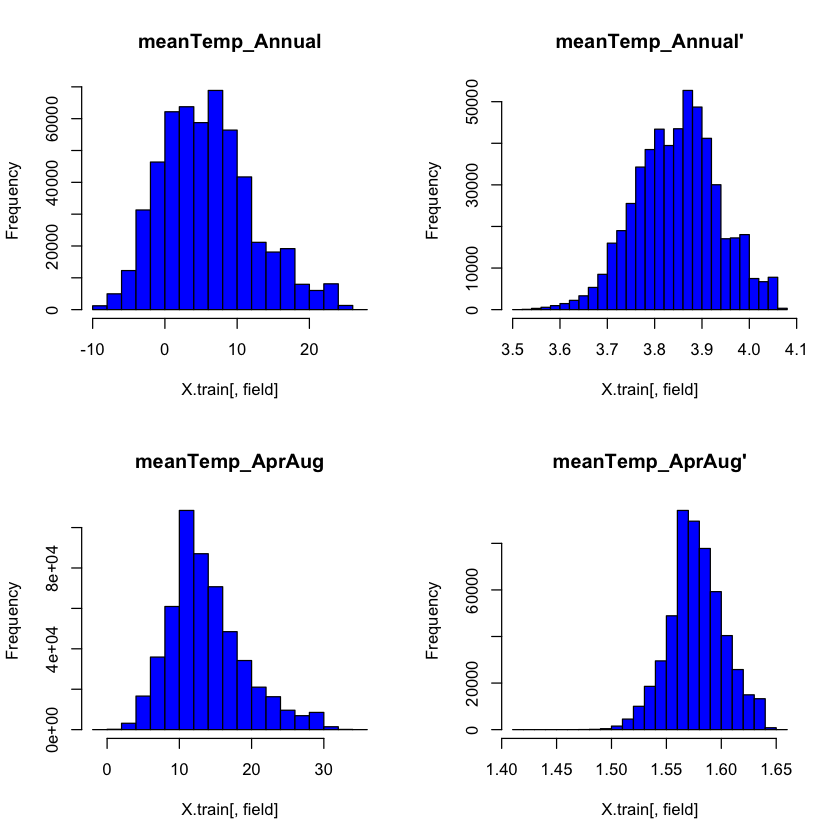

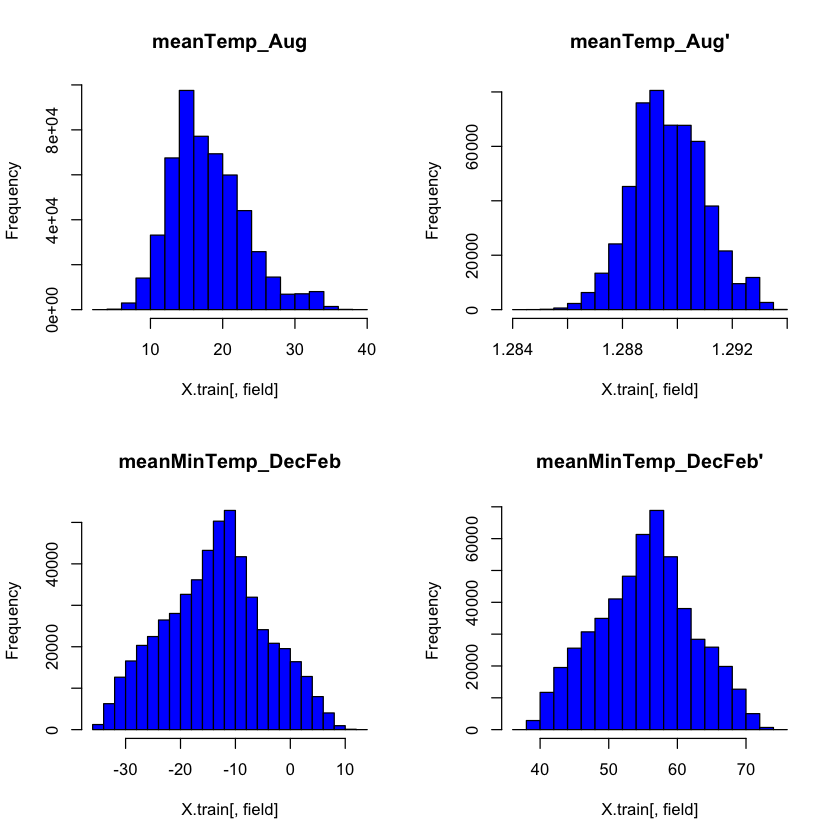

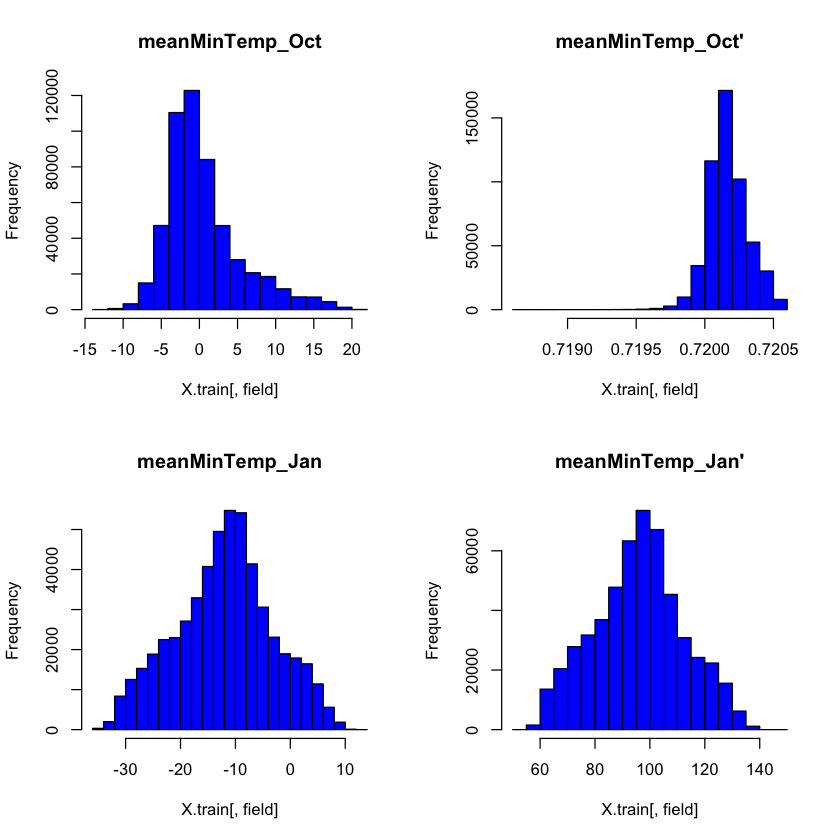

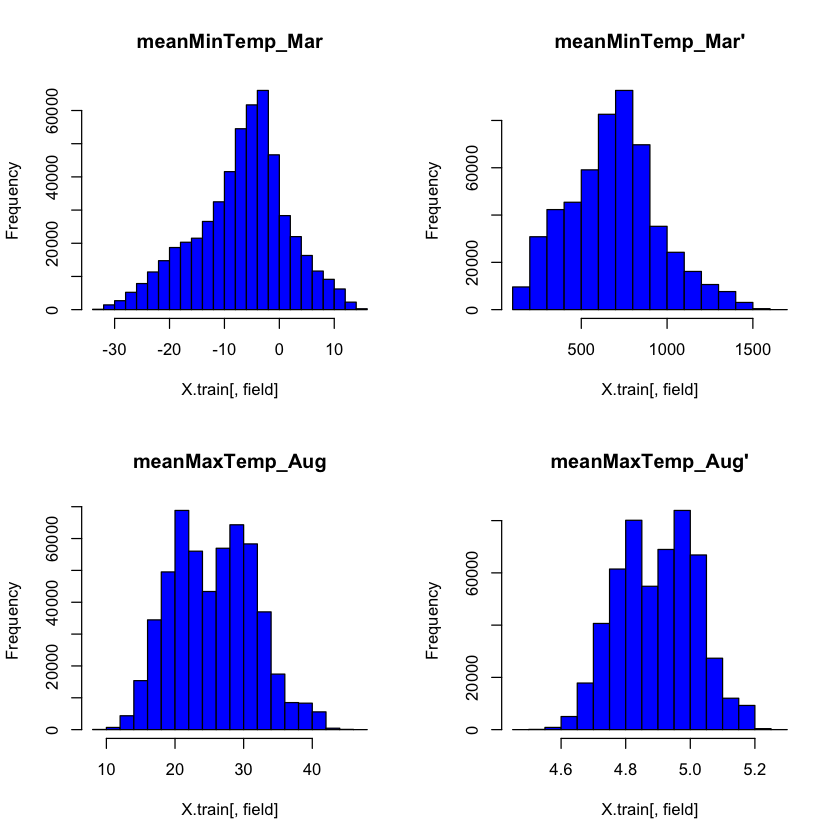

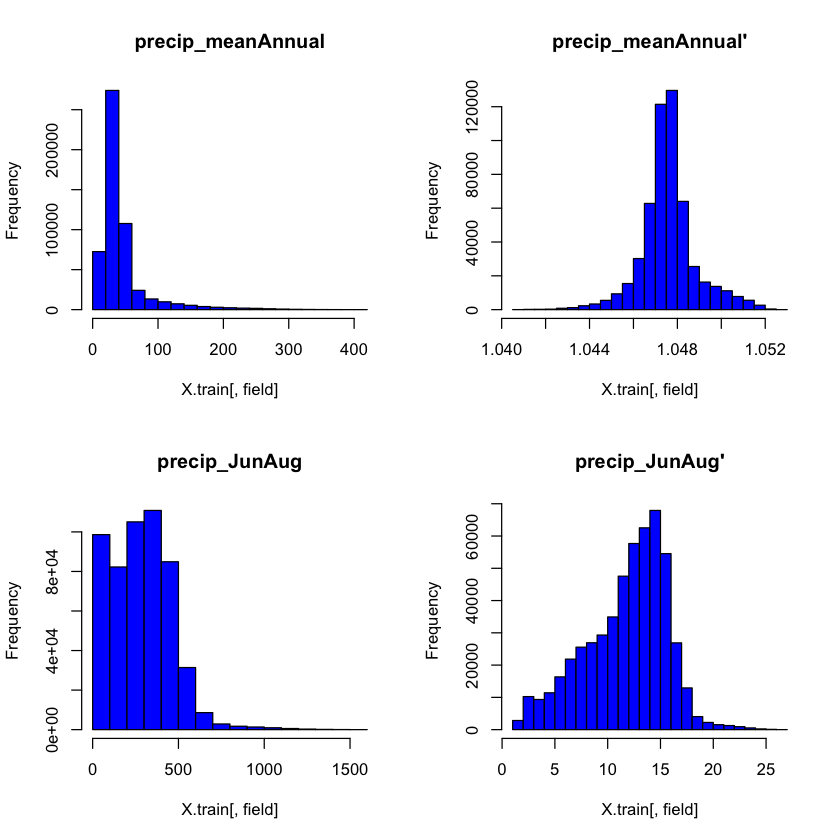

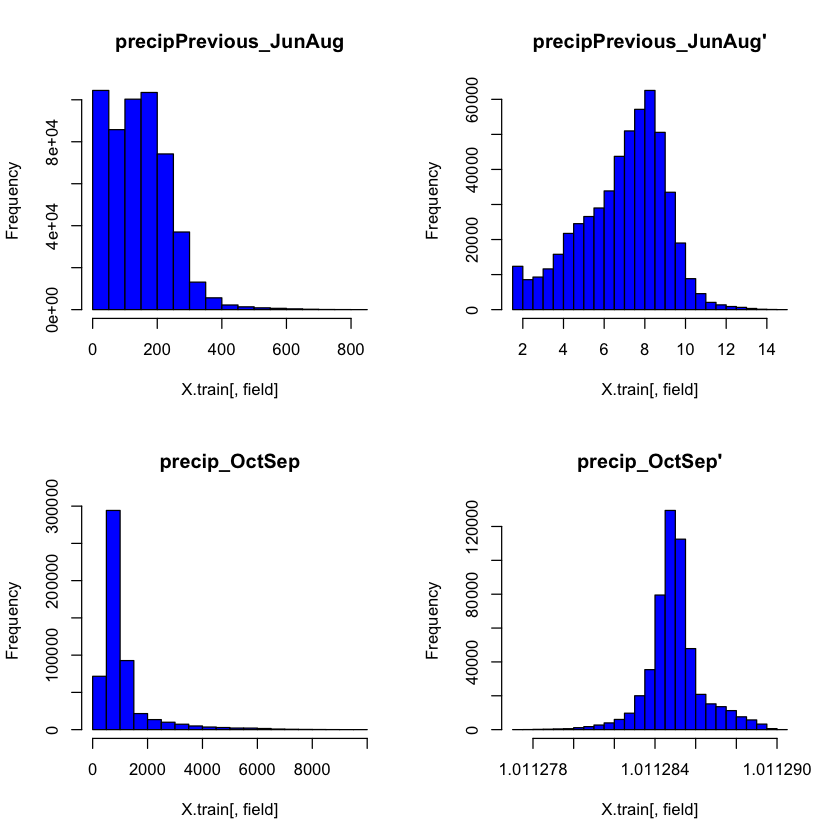

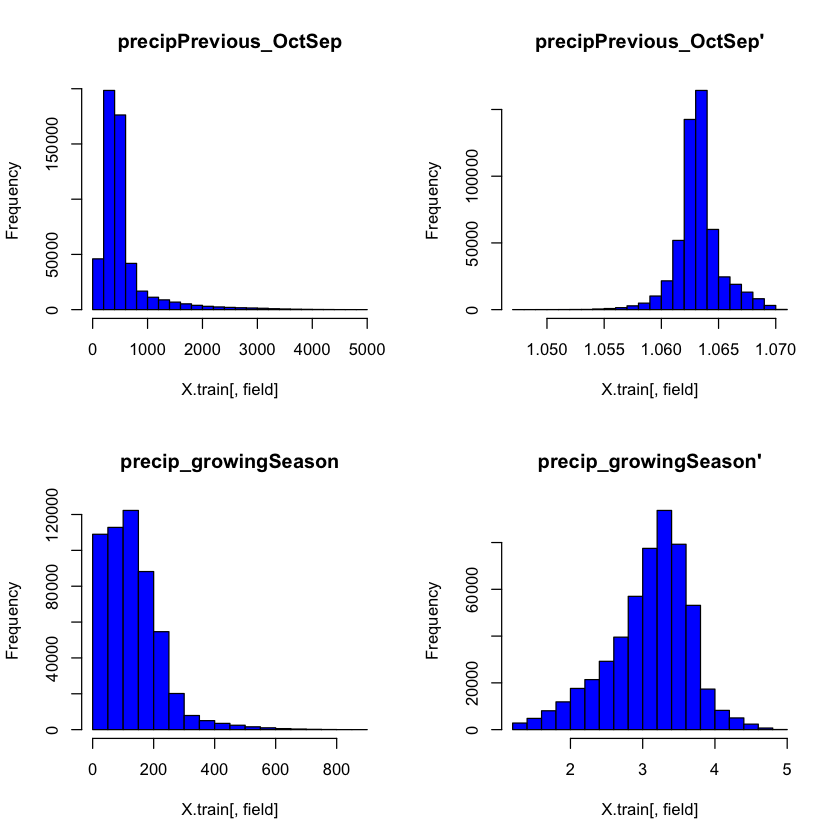

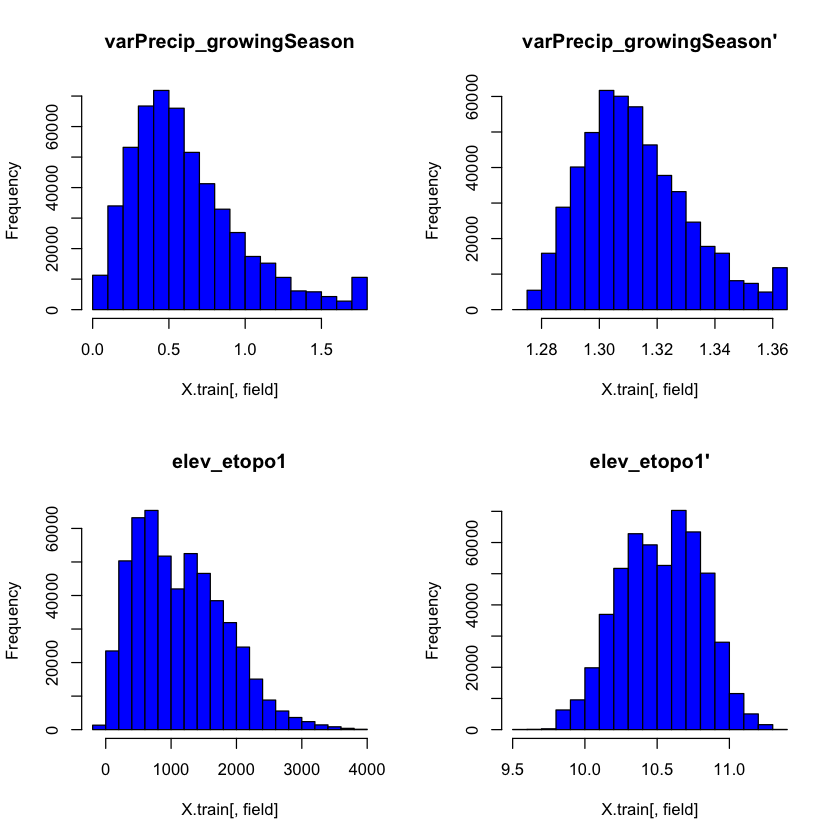

In [53]:
par(mfrow=c(2, 2))
for (field in names(X.train)) {
  if (!(field %in% ignore)) {
    hist(X.train[, field], main=field, col=4)
      
    min.x <- min(c(X.train[, field], X.valid[, field], X.test[, field]), 
                 na.rm=T)
    X.train[, field] <- (
        (X.train[, field] + abs(min.x) + 1)^best.exps[field])
    X.valid[, field] <- (
        (X.valid[, field] + abs(min.x) + 1)^best.exps[field])
    X.train[, field] <- (
        (X.train[, field] + abs(min.x) + 1)^best.exps[field])
    
    hist(X.train[, field], 
         main=paste(field, "'", sep=''), col=4)
  }
}

In [55]:
names(X.train)

[1] "beetle"                  "year"                   
 [3] "meanTemp_Annual"         "meanTemp_AprAug"        
 [5] "meanTemp_Aug"            "meanMinTemp_DecFeb"     
 [7] "meanMinTemp_Oct"         "meanMinTemp_Jan"        
 [9] "meanMinTemp_Mar"         "meanMaxTemp_Aug"        
[11] "precip_meanAnnual"       "precip_JunAug"          
[13] "vegetation"              "precipPrevious_JunAug"  
[15] "precip_OctSep"           "precipPrevious_OctSep"  
[17] "precip_growingSeason"    "varPrecip_growingSeason"
[19] "elev_etopo1"             "lat"                    
[21] "lon"                     "x"                      
[23] "y"

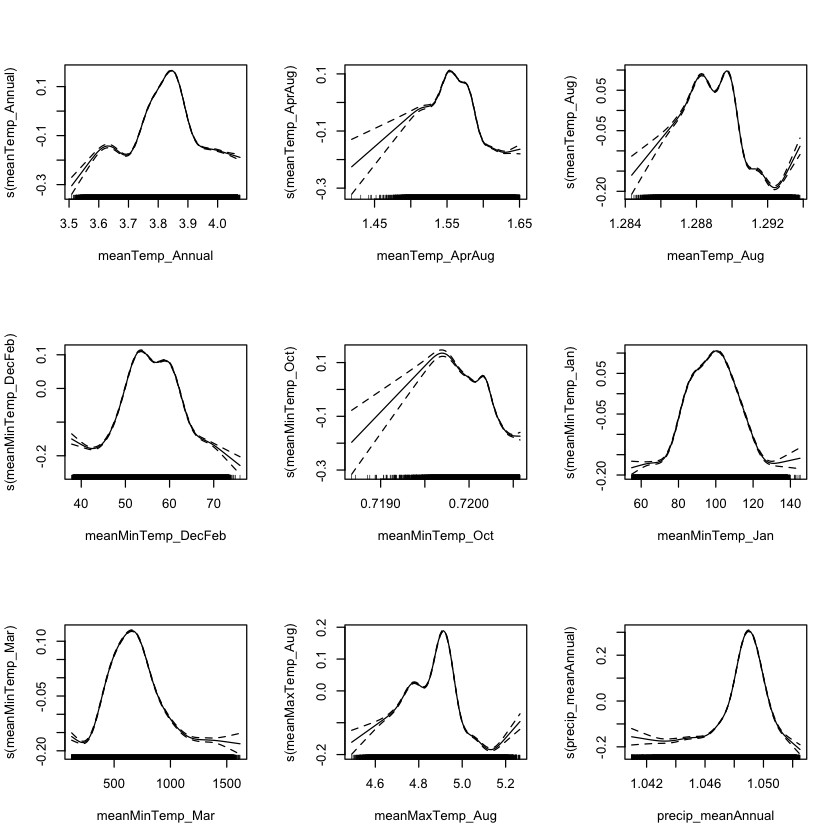

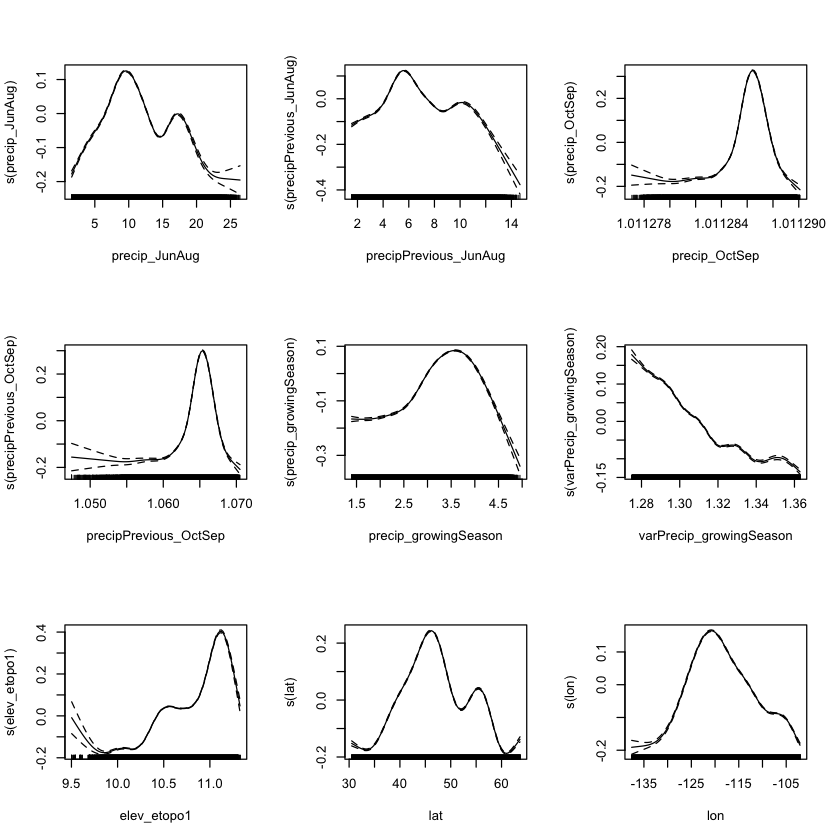

In [57]:
# Examine non-linear relationships
ignore <- c('beetle', 'year', 'x', 'y', 'vegetation')

par(mfrow=c(3, 3))
for (field in names(X.train)) {
  if (!(field %in% ignore)) {
    gam.mod <- gam(X.train$beetle ~ s(X.train[, field]))
    plot(gam.mod, xlab=field, ylab=paste('s(', field, ')', sep=''))     
  }
}

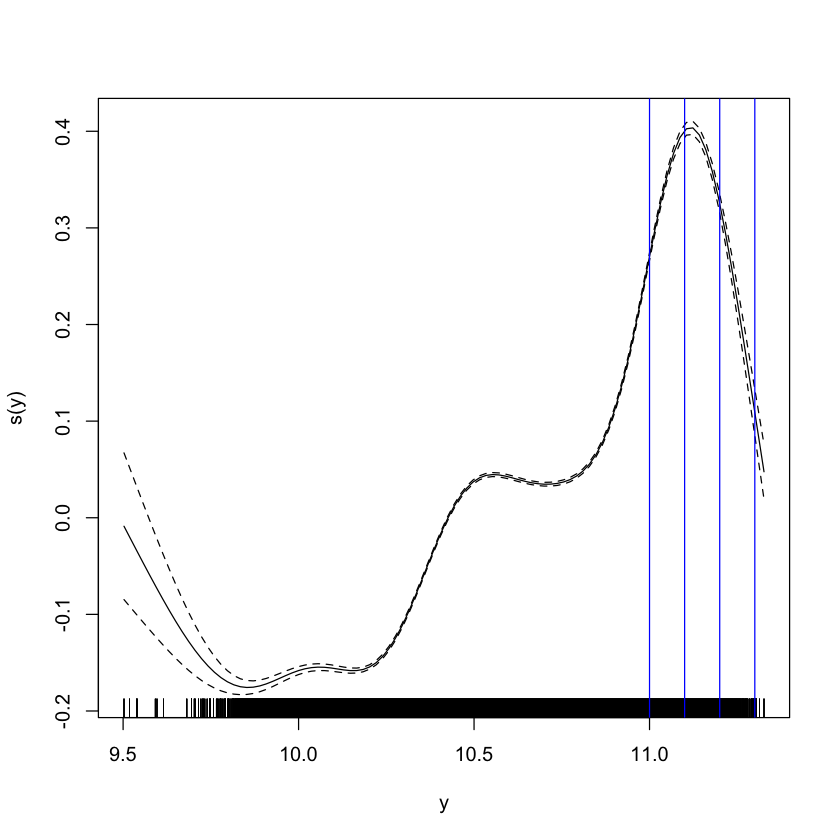

In [63]:
gam.mod <- gam(X.train$beetle ~ s(X.train[, 'elev_etopo1']))
plot(gam.mod, xlab=field, ylab=paste('s(', field, ')', sep=''))
abline(v=c(11.0, 11.1, 11.2, 11.3), col=4)

In [66]:
# Segment
segment.data <- function(data) {
  data$meanTemp_Annual_L385 <- 1 * (data$meanTemp_Annual < 3.85)
  data$meanTemp_Annual_L155 <- 1 * (data$meanTemp_Annual < 1.55)
  data$meanTemp_Aug_L129 <- 1 * (data$meanTemp_Aug < 1.29)
  data$meanTemp_Aug_G1292 <- 1 * (data$meanTemp_Aug >= 1.292)
  data$meanMinTemp_DecFeb_L55 <- 1 * (data$meanMinTemp_DecFeb < 55)
  data$meanMinTemp_Oct_L71975 <- 1 * (data$meanMinTemp_Oct < 0.71975)
  data$meanMinTemp_Jan_L100 <- 1 * (data$meanMinTemp_Jan < 100)
  data$meanMinTemp_Mar_L700 <- 1 * (data$meanMinTemp_Mar < 700)
  data$meanMaxTemp_Aug_L495 <- 1 * (data$meanMaxTemp_Aug < 4.95)
  data$precip_meanAnnual_L1049 <- 1 * (data$precip_meanAnnual < 1.049)
  data$precip_JunAug_L10 <- 1 * (data$precip_JunAug < 10)
  data$precipPrevious_JunAug_L6 <- 1 * (data$precipPrevious_JunAug < 6)
  data$precip_OctSep_L10112864 <- 1 * (data$precip_OctSep < 1.0112864)
  data$precipPrevious_OctSep_L1065 <- (1 * 
                                       (data$precipPrevious_OctSep < 1.065))
  data$precip_growingSeason_L35 <- 1 * (data$precip_growingSeason < 3.5)
  data$elev_etopo1_L111 <- 1 * (data$elev_etopo1 < 11.1)
  data$lat_L45 <- 1 * (data$lat < 45)
  data$lon_Lm120 <- 1 * (data$lon < -120)
    
  data
}

In [68]:
X.train <- segment.data(X.train)
X.valid <- segment.data(X.valid)
X.test  <- segment.data(X.test)

In [85]:
names(X.train)
length(names(X.train))

[1] "beetle"                      "year"                       
 [3] "meanTemp_Annual"             "meanTemp_AprAug"            
 [5] "meanTemp_Aug"                "meanMinTemp_DecFeb"         
 [7] "meanMinTemp_Oct"             "meanMinTemp_Jan"            
 [9] "meanMinTemp_Mar"             "meanMaxTemp_Aug"            
[11] "precip_meanAnnual"           "precip_JunAug"              
[13] "vegetation"                  "precipPrevious_JunAug"      
[15] "precip_OctSep"               "precipPrevious_OctSep"      
[17] "precip_growingSeason"        "varPrecip_growingSeason"    
[19] "elev_etopo1"                 "lat"                        
[21] "lon"                         "x"                          
[23] "y"                           "meanTemp_Annual_L385"       
[25] "meanTemp_Annual_L155"        "meanTemp_Aug_L129"          
[27] "meanTemp_Aug_G1292"          "meanMinTemp_DecFeb_L55"     
[29] "meanMinTemp_Oct_L71975"      "meanMinTemp_Jan_L100"       
[31] "meanMinTemp_Mar_L700"        "meanMaxTemp_Aug_L495"       
[33] "precip_meanAnnual_L1049"     "precip_JunAug_L10"          
[35] "precipPrevious_JunAug_L6"    "precip_OctSep_L10112864"    
[37] "precipPrevious_OctSep_L1065" "precip_growingSeason_L35"   
[39] "elev_etopo1_L111"            "lat_L45"                    
[41] "lon_Lm120"

[1] 41

In [78]:
# Explore interaction terms
interaction.coefs <- c()

for (i in 2:(length(names(X.train)) - 1)) {
  for (j in (i + 1):(length(names(X.train)))) {
    f.string <- paste(
      'beetle ~ ', names(X.train)[i], ' * ', names(X.train)[j])
    interaction <- paste(names(X.train)[i], names(X.train)[j], sep=':')
    m <- glm(as.formula(f.string), data=X.train, family=binomial)
    if (dim(summary(m)$coef)[1] >= 4) {
      p <- summary(m)$coef[4, 4]
      if (p < 0.001) {
        interaction.coefs[interaction] <- summary(m)$coef[4]   
      }
    } else {
      interaction.coefs[interaction] <- 0
    }
  }
}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

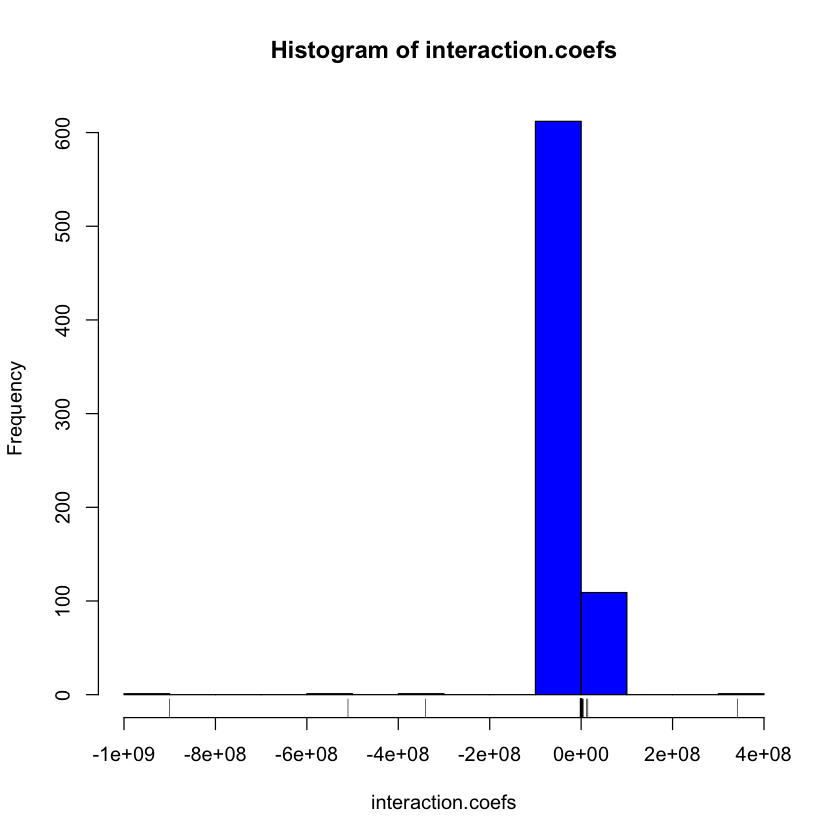

In [79]:
hist(interaction.coefs, col=4)
rug(interaction.coefs)

Warning message in log(interaction.coefs):
“NaNs produced”Warning message in log(interaction.coefs):
“NaNs produced”

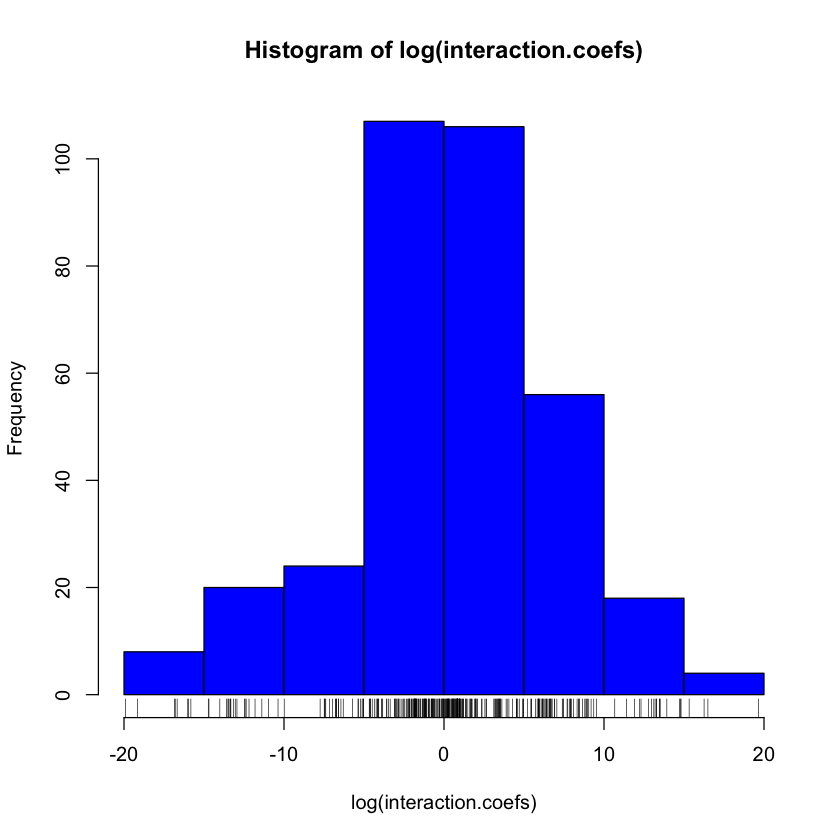

In [81]:
hist(log(interaction.coefs), col=4)
rug(log(interaction.coefs))

In [82]:
length(interaction.coefs)
quantile(interaction.coefs, probs=seq(0, 1, 0.1))

[1] 725

0%           10%           20%           30%           40% 
-9.008457e+08 -4.207986e+01 -1.089150e+00 -2.019700e-01 -2.968139e-05 
          50%           60%           70%           80%           90% 
 0.000000e+00  9.363444e-03  3.115678e-01  2.309032e+00  3.250665e+02 
         100% 
 3.415598e+08

In [86]:
length(interaction.coefs[interaction.coefs <= -1])
length(interaction.coefs[interaction.coefs >= 1])

[1] 155

[1] 184

In [87]:
# Most negative coefs in order of magnitude
neg.interactions <- (sort(interaction.coefs[interaction.coefs <= -0.5]))
names(neg.interactions)[1:10]

[1] "meanMinTemp_Oct:precip_OctSep"       
 [2] "precip_meanAnnual:precip_OctSep"     
 [3] "precip_OctSep:precipPrevious_OctSep" 
 [4] "meanTemp_Aug:meanMinTemp_Oct"        
 [5] "precip_OctSep:lon_Lm120"             
 [6] "precip_OctSep:precip_growingSeason"  
 [7] "precip_OctSep:meanMaxTemp_Aug_L495"  
 [8] "meanMinTemp_Oct:precip_meanAnnual"   
 [9] "precip_OctSep:meanTemp_Aug_L129"     
[10] "precip_OctSep:meanMinTemp_Oct_L71975"

In [88]:
# Most positive
pos.interactions <- (sort(interaction.coefs[interaction.coefs >= 0.5]))
n <- length(pos.interactions)
names(pos.interactions)[(n - 10):n]

[1] "precip_OctSep:elev_etopo1"                
 [2] "precip_OctSep:elev_etopo1_L111"           
 [3] "precip_OctSep:lat_L45"                    
 [4] "precip_OctSep:precip_growingSeason_L35"   
 [5] "precip_OctSep:precipPrevious_OctSep_L1065"
 [6] "precip_OctSep:precip_meanAnnual_L1049"    
 [7] "precip_OctSep:precip_OctSep_L10112864"    
 [8] "meanMaxTemp_Aug:precip_OctSep"            
 [9] "meanTemp_AprAug:precip_OctSep"            
[10] "precip_OctSep:varPrecip_growingSeason"    
[11] "meanTemp_Aug:precip_OctSep"

In [90]:
dim(X.train)

[1] 529623     41

In [103]:
add.interaction.term <- function(data, interaction) {
  terms <- unlist(strsplit(interaction, ':'))
  data[, interaction] <- data[, terms[1]] * data[, terms[2]]
  data
}

In [107]:
add.all.interactions <- function(data, interactions) {
  for (interaction in interactions) {
    data <- add.interaction.term(data, interaction)
  }
    
  data
}

In [109]:
test.df <- data.frame(a=c(0, 0, 0, 0, 1, 1, 1, 1), 
                      b=c(0, 0, 1, 1, 0, 0, 1, 1),
                      c=c(0, 1, 0, 1, 0, 1, 0, 1))
interactions <- c('a:b', 'a:c', 'b:c')
add.all.interactions(test.df, interactions)

a,b,c,a:b,a:c,b:c
0,0,0,0,0,0
0,0,1,0,0,0
0,1,0,0,0,0
0,1,1,0,0,1
1,0,0,0,0,0
1,0,1,0,1,0
1,1,0,1,0,0
1,1,1,1,1,1


In [111]:
interactions <- c(names(neg.interactions), names(pos.interactions))
length(interactions)

[1] 388

In [114]:
X.train <- add.all.interactions(X.train, interactions)
X.valid <- add.all.interactions(X.valid, interactions)
X.test  <- add.all.interactions(X.test, interactions)

In [8]:
X.train <- read.csv(paste(DATA_PATH, 'X_big_train.csv'))
X.valid <- read.csv(paste(DATA_PATH, 'X_big_valid.csv'))
X.test  <- read.csv(paste(DATA_PATH, 'X_big_test.csv'))

y.train <- read.csv(paste(DATA_PATH, 'y_big_train.csv'))
y.valid <- read.csv(paste(DATA_PATH, 'y_big_valid.csv'))
y.test  <- read.csv(paste(DATA_PATH, 'y_big_test.csv'))

X.train <- rbind(y.train, X.train)
X.valid <- rbind(y.train, X.valid)
X.test  <- rbind(y.train, X.test)

In [9]:
X_train <- X.train[, -1]
y_train <- X.train[, 1]

X_valid <- X.valid[, -1]
y_valid <- X.valid[, 1]

X_test <- X.test[, -1]
y_test <- X.test[, 1]

In [10]:
write.csv(X_train, paste(DATA_PATH, 'X_big_train.csv', sep=''), row.names=F)
write.csv(y_train, paste(DATA_PATH, 'y_big_train.csv', sep=''), row.names=F)

write.csv(X_valid, paste(DATA_PATH, 'X_big_valid.csv', sep=''), row.names=F)
write.csv(y_valid, paste(DATA_PATH, 'y_big_valid.csv', sep=''), row.names=F)

write.csv(X_test, paste(DATA_PATH, 'X_big_test.csv', sep=''), row.names=F)
write.csv(y_test, paste(DATA_PATH, 'y_big_test.csv', sep=''), row.names=F)

In [11]:
list.files(DATA_PATH)

[1] " X_big_test.csv"     " X_big_train.csv"    " X_big_valid.csv"   
 [4] " y_big_test.csv"     " y_big_train.csv"    " y_big_valid.csv"   
 [7] "weights.bestNN.hdf5" "X_big_test.csv"      "X_big_train.csv"    
[10] "X_big_valid.csv"     "X_test.csv"          "X_train.csv"        
[13] "X_valid.csv"         "y_big_test.csv"      "y_big_train.csv"    
[16] "y_big_valid.csv"     "y_test.csv"          "y_train.csv"        
[19] "y_valid.csv"